<a href="https://colab.research.google.com/github/MerkulovDaniil/split-sgd/blob/master/Code/Continious_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  8%|▊         | 4/50 [00:00<00:01, 32.43it/s]

QR finished
🤖 GF trajectory started


100%|██████████| 50/50 [00:01<00:00, 25.36it/s]


🤖 GF trajectory finished
🤖 Splitting trajectory started
🤖 Splitting trajectory finished
🤖 Splitting trajectory started
🤖 Splitting trajectory finished


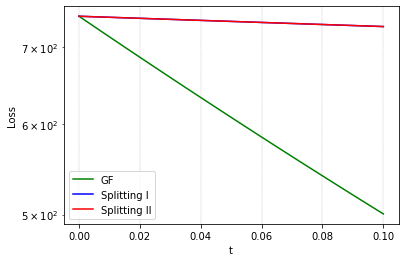

In [77]:
# ======= Libraries =======
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm, qr
import copy
from tqdm import tqdm

# ======= Function definitions =======

def generate_problem(p, n, lstsq=False, epsilon = 1e-2):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + epsilon*np.random.randn(n) # right-hand side
    theta_0 = np.random.randn(p)

    if lstsq == True:
        theta_lstsq = np.linalg.lstsq(X,y)[0]
        return X, theta_0, y, theta_lstsq
    else:
        return X, theta_0, y

def solve_local_problem(Q, R, theta_0, y_batch, h, n):
    R_it = np.linalg.inv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return 1/n*np.linalg.norm(X @ theta - y)**2
    elif len(X.shape) == 3:
        s, b, p = Xs.shape
        n = b*s
        loss = 0
        for i_batch in range(s):
            loss += 1/n*np.linalg.norm(X[i_batch] @ theta - y[i_batch])**2
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')


def gradient(X, theta, y):
    n, p = X.shape
    return 1/n* X.T @ (X @ theta - y)

def make_SGD_step(X_batch, theta_0, y_batch, h):
    theta = theta_0 - h*gradient(X_batch, theta_0, y_batch)
    return theta

def relative_error(theta, thetalstsq=0):
    p = len(theta)
    if np.linalg.norm(thetalstsq) != 0:
        return(np.linalg.norm(theta - thetalstsq)/np.linalg.norm(thetalstsq))
    else:
        return(np.linalg.norm(theta - np.ones(p))/np.linalg.norm(np.ones(p)))

def logarithmic_norm(A):
    w,v = np.linalg.eig((A + A.T)/2)
    return(max(w))

def gradient_flow_trajectory(Q, R, theta_0, y, ts):
    p, n = Q.shape
    print('🤖 GF trajectory started')
    thetas = []
    losses = []

    for t in tqdm(ts):
        theta_t = solve_local_problem(Q, R, theta_0, y, t, n)
        thetas.append(theta_t)
        loss_t = loss(R.T@Q.T, theta_t, y)
        losses.append(loss_t)
    
    print('🤖 GF trajectory finished')

    return thetas, losses

def sgd_trajectory(Xs, theta_0, ys, ts):
    print('🤖 SGD trajectory started')
    s, b, p = Xs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    
    for i_t in range(len(ts)):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s):
            theta_t = make_SGD_step(Xs[i_batch], theta_t, ys[i_batch], h)
       
    
    print('🤖 SGD trajectory finished')

    return thetas, losses

def spl_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting trajectory started')
    s, b, p = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in range(len(ts)):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s):
            # ts_new.append(ts[i_t] + i_batch*h/s)
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h, n)
       
    
    print('🤖 Splitting trajectory finished')

    return thetas, losses

def spl2_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting trajectory started')
    s, b, p = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in range(len(ts)):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s-1):
            # ts_new.append(ts[i_t] + i_batch*h/(2*s))
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
        
        # ts_new.append(ts[i_t] + h/(*s))
        # thetas.append(theta_t)
        # loss_t = loss(Xs, theta_t, ys)
        # losses.append(loss_t)
        theta_t = solve_local_problem(Qs[s-1], Rs[s-1], theta_t, ys[s-1], h, n)

        for j_batch in range(s-1):
            i_batch = s - (j_batch + 2) 
            # ts_new.append(ts[i_t] + j_batch*h/(2*s))
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
    
    print('🤖 Splitting trajectory finished')

    return thetas, losses

# ======= Problem generation =======

hs = np.logspace(-2, -1, 12)
p = 300
n = 300
s = 20
b = 15
n_max_iter = 2000
epsilon = 0
n_experiments = 30

X, theta_0, y, theta_lstsq = generate_problem(p,n, lstsq=True)

Xs = np.zeros((s, b, p))
ys = np.zeros((s, b))
Qs = np.zeros((s, p, b))
Rs = np.zeros((s, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(s):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')

theta_0     = np.random.randn(p)
total_time  = 0.1
learning_rate = 4e-3
h = learning_rate*s
ts_gf = np.linspace(0, total_time)
ts_sgd = np.linspace(0, total_time, 10)
ts_spl = np.linspace(0, total_time, 20)

# ======= Trajectory generation =======
thetas_gf, losses_gf    = gradient_flow_trajectory(Q, R, theta_0, y, ts_gf)
# thetas_sgd, losses_sgd  = sgd_trajectory(Xs, theta_0, ys, ts_sgd)
thetas_spl, losses_spl = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl)
thetas_spl2, losses_spl2 = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl)

plt.figure(figsize=(6.0, 4.0))
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'go', label = 'True')
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'g')
plt.semilogy(ts_gf, losses_gf, 'g', label = 'GF')
# plt.semilogy(ts_sgd, losses_sgd, 'r', label = 'SGD as splitting')
plt.semilogy(ts_spl, losses_spl, 'b', label = 'Splitting I')
plt.semilogy(ts_spl, losses_spl2, 'r', label = 'Splitting II')
plt.grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
plt.xlabel('t')
plt.ylabel('Loss')
plt.legend()

# plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.savefig('convergence_lls.pdf')
plt.show()

In [78]:
[losses_spl2[i]/losses_spl[i] for i in range(len(losses_spl2))]

[1.0,
 1.0000000038989045,
 1.0000000078014124,
 1.0000000117075165,
 1.000000015617207,
 1.0000000195304741,
 1.0000000234473105,
 1.000000027367709,
 1.000000031291657,
 1.0000000352191478,
 1.0000000391501722,
 1.0000000430847218,
 1.000000047022788,
 1.0000000509643605,
 1.0000000549094321,
 1.0000000588579936,
 1.0000000628100358,
 1.0000000667655502,
 1.0000000707245276,
 1.0000000746869595]